In [1]:
import tensorflow as tf

seed = 123
tf.random.set_seed(seed)

In [2]:
img_height = 480
img_width = 640
batch_size = 5

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset/',
    validation_split=0.2,   
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset/',
    validation_split=0.2,   
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 556 files belonging to 6 classes.
Using 445 files for training.
Found 556 files belonging to 6 classes.
Using 111 files for validation.


In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [58]:
num_classes = 6
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(2, 3, strides=4, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(4, 3, strides=2, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(4, 3, strides=2, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

In [59]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy', 'mse']
)

In [60]:
history = model.fit(
    train_ds, validation_data = val_ds, epochs = 20
)

Epoch 1/20
89/89 [==============================] - 1s 10ms/step - loss: 1.7264 - accuracy: 0.2787 - mse: 6.8989 - val_loss: 1.5402 - val_accuracy: 0.5045 - val_mse: 6.3748
Epoch 2/20
89/89 [==============================] - 1s 8ms/step - loss: 1.1583 - accuracy: 0.5640 - mse: 7.1366 - val_loss: 0.9387 - val_accuracy: 0.7117 - val_mse: 6.6697
Epoch 3/20
89/89 [==============================] - 1s 7ms/step - loss: 0.7065 - accuracy: 0.7798 - mse: 7.1590 - val_loss: 0.6862 - val_accuracy: 0.8288 - val_mse: 6.6981
Epoch 4/20
89/89 [==============================] - 1s 7ms/step - loss: 0.4581 - accuracy: 0.8809 - mse: 7.1529 - val_loss: 0.5971 - val_accuracy: 0.8288 - val_mse: 6.7488
Epoch 5/20
89/89 [==============================] - 1s 8ms/step - loss: 0.3395 - accuracy: 0.9011 - mse: 7.1554 - val_loss: 0.5101 - val_accuracy: 0.8378 - val_mse: 6.7705
Epoch 6/20
89/89 [==============================] - 1s 8ms/step - loss: 0.2811 - accuracy: 0.9146 - mse: 7.1579 - val_loss: 0.4005 - val_ac

In [61]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 120, 160, 2)       56        
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 60, 80, 2)        0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 29, 39, 4)         76        
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 14, 19, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 6, 9, 4)           148       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 3, 4, 4)         

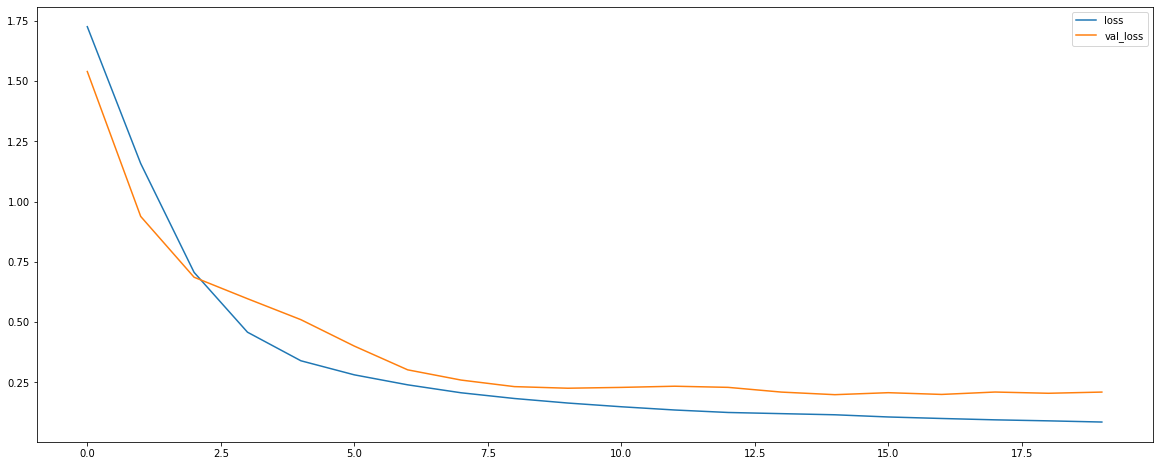

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

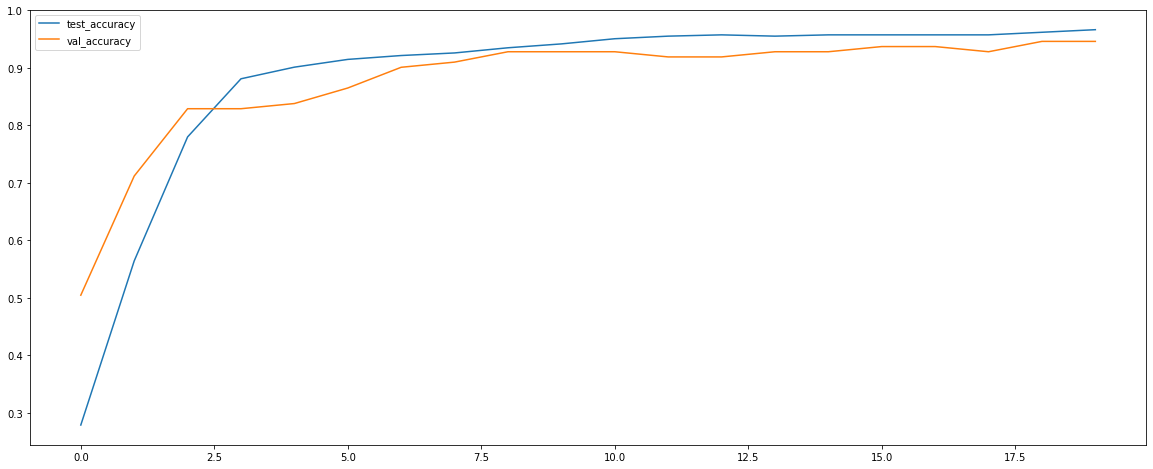

In [63]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'], label='test_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

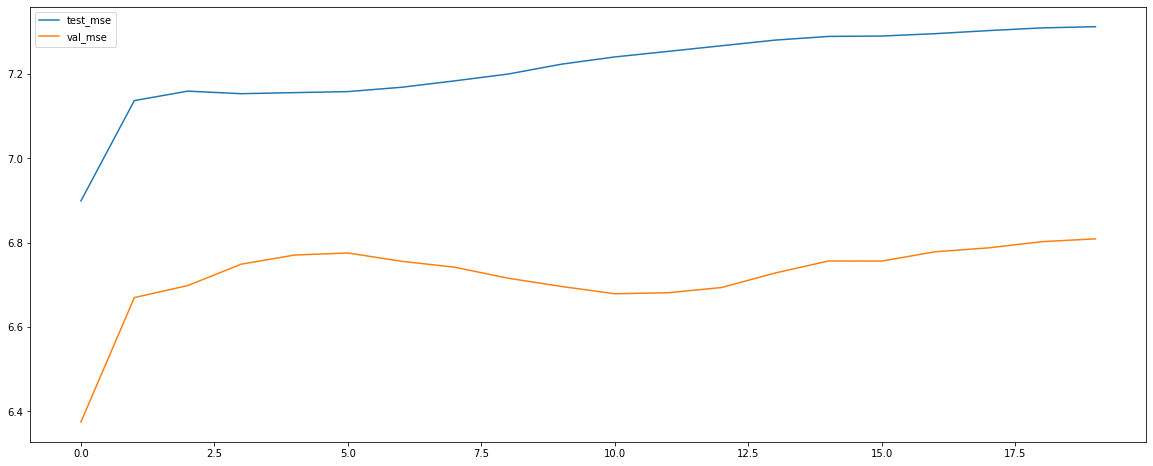

In [64]:
plt.figure(figsize=(20,8))
plt.plot(history.history['mse'], label='test_mse')
plt.plot(history.history['val_mse'], label='val_mse')
plt.legend()
plt.show()

In [65]:
model.save_weights('./checkpoints/checkpoint_6_21_95percent')

In [66]:
predictions = model.predict(val_ds)
pred = tf.argmax(predictions, axis=1)

In [67]:
model.evaluate(val_ds)

23/23 [==============================] - 0s 5ms/step - loss: 0.2095 - accuracy: 0.9459 - mse: 6.8090


[0.20954783260822296, 0.9459459185600281, 6.808960437774658]

In [68]:
import numpy as np
labels = np.concatenate([y for x, y in val_ds], axis=0)
cf_mat = tf.math.confusion_matrix(labels, pred)
print(cf_mat)

tf.Tensor(
[[23  0  0  0  0  0]
 [ 0 15  0  0  3  0]
 [ 0  0 16  0  0  0]
 [ 0  0  0 20  0  0]
 [ 0  1  0  1 18  0]
 [ 1  0  0  0  0 13]], shape=(6, 6), dtype=int32)


In [69]:
val_images = np.concatenate([x for x,y in val_ds], axis=0)

In [70]:
val_images.shape, pred.numpy().shape, labels.shape

((111, 480, 640, 3), (111,), (111,))

In [ ]:
from matplotlib.image import imsave
with open('out/results.txt', 'w') as f:
    f.write('num gt pred\n')
    for i in range(111):
        imsave('out/'+str(i)+'.jpg', val_images[i])
        f.write('{} {} {}\n'.format(i, labels[i], pred.numpy()[i]))
    

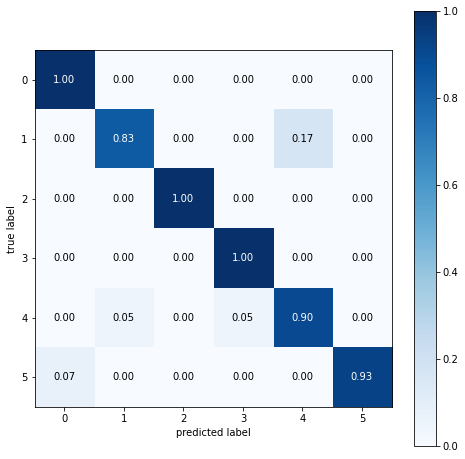

In [71]:
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cf_mat.numpy(), figsize = (8,8), colorbar = True, show_normed = True, show_absolute = False)
plt.savefig("confusion_matrix.pdf")
plt.show()


In [72]:
a = model.get_weights()

In [73]:
d_conv1_weight = a[0]
d_conv1_bias = a[1]
d_conv2_weight = a[2]
d_conv2_bias = a[3]
d_conv3_weight = a[4]
d_conv3_bias = a[5]
d_dense1_weight = a[6]
d_dense1_bias = a[7]
d_dense2_weight = a[8]
d_dense2_bias = a[9]

In [74]:
def get_weight_conv(conv_weight, weight_name):
    a,b,c,d = conv_weight.shape
    out = 'float [' + str(a*b*c*d) + '] ' + weight_name + ' = {'
    for i in range(d):
        for j in range(c):
            for k in range(a):
                for l in range(b):
                    out += str(conv_weight[k,l,j,i])+'f, '
    return out[:-2] + '};\n\n'

def get_weight_dense(dense_weight, weight_name):
    a,b = dense_weight.shape
    out = 'float [' + str(a*b) + '] ' + weight_name + ' = {'
    for k in range(a):
        for l in range(b):
            out += str(dense_weight[k,l])+'f, '
    return out[:-2] + '};\n\n'

def get_bias(bias, bias_name):
    a = bias.shape[0]
    out = 'float [' + str(a) + '] ' + bias_name + ' = {'
    for k in range(a):
        out += str(bias[k])+'f, '
    return out[:-2] + '};\n\n'

In [75]:
with open('gmnet_params.h', 'w') as f:
    f.write(get_weight_conv(d_conv1_weight, 'd_conv1_weight'))
    f.write(get_bias(d_conv1_bias, 'd_conv1_bias'))
    f.write(get_weight_conv(d_conv2_weight, 'd_conv2_weight'))
    f.write(get_bias(d_conv2_bias, 'd_conv2_bias'))
    f.write(get_weight_conv(d_conv3_weight, 'd_conv3_weight'))
    f.write(get_bias(d_conv3_bias, 'd_conv3_bias'))
    f.write(get_weight_dense(d_dense1_weight, 'd_dense1_weight'))
    f.write(get_bias(d_dense1_bias, 'd_dense1_bias'))
    f.write(get_weight_dense(d_dense2_weight, 'd_dense2_weight'))
    f.write(get_bias(d_dense2_bias, 'd_dense2_bias'))